# Customer Segmentation & Basket Mix Analysis

#### This notebook analyzes the Online Retail dataset, which contains transactional data for a UK based e-commerce store from 2010 to 2011. The objective is to perform a customer segmentation using RFM analysis to understand customer purchasing behavior, and to conduct a market basket analysis to uncover associations between products frequently bought together. These insights aim to support data driven business strategies for personalized marketing and product bundling

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

## Data Wrangling

In [2]:
df = pd.read_excel('Online Retail.xlsx')

In [3]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
df.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,541909.000000,541909,541909.000000,406829.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114,15287.690570
min,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000
25%,1.000000,2011-03-28 11:34:00,1.250000,13953.000000
50%,3.000000,2011-07-19 17:17:00,2.080000,15152.000000
75%,10.000000,2011-10-19 11:27:00,4.130000,16791.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,218.081158,NaN,96.759853,1713.600303


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [6]:
df.shape

(541909, 8)

#### After inspecting the data in excel the negative values in the Quantity and Unit Price columns stood out. They had visibly different product descriptions similar to that of credit transactions such as returns, discounts, or carrier charges, so we'll remove these rows from the dataset

In [7]:
df_purchase = df[(df.Quantity > 0) & (df.UnitPrice > 0)].copy()
df_purchase

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


#### Now we'll deal with any null values

In [8]:
print(df_purchase.isnull().sum(), '\n')
print(df_purchase.shape,'\n')

InvoiceNo           0
StockCode           0
Description         0
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     132220
Country             0
dtype: int64 

(530104, 8) 



#### We have 132,220 empty CustomerID fields, we could fill these in with "Unknown" but then it will skew our data of customers creating one huge customer that will certainly be an outstanding outlier, so instead we'll remove these rows from the database

In [9]:
df_purchase = df_purchase[df_purchase.CustomerID.notna()]
df_purchase.CustomerID = df_purchase.CustomerID.astype(int)
print(df_purchase.isnull().sum(), '\n')
print(df_purchase.shape,'\n')

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64 

(397884, 8) 



#### The Description column has a few formatting and spacing inconsistencies 

In [10]:
df_purchase['Description'] = df_purchase['Description'].str.replace('.','').str.upper().str.strip()
df_purchase['Description'] = df_purchase['Description'].replace('\s+',' ',regex = True)
df_purchase.Description = df_purchase.Description.str.replace(r"'S\b", "", regex=True)

df_purchase.Description.unique().tolist()[:50]

['WHITE HANGING HEART T-LIGHT HOLDER',
 'WHITE METAL LANTERN',
 'CREAM CUPID HEARTS COAT HANGER',
 'KNITTED UNION FLAG HOT WATER BOTTLE',
 'RED WOOLLY HOTTIE WHITE HEART',
 'SET 7 BABUSHKA NESTING BOXES',
 'GLASS STAR FROSTED T-LIGHT HOLDER',
 'HAND WARMER UNION JACK',
 'HAND WARMER RED POLKA DOT',
 'ASSORTED COLOUR BIRD ORNAMENT',
 'POPPY PLAYHOUSE BEDROOM',
 'POPPY PLAYHOUSE KITCHEN',
 'FELTCRAFT PRINCESS CHARLOTTE DOLL',
 'IVORY KNITTED MUG COSY',
 'BOX OF 6 ASSORTED COLOUR TEASPOONS',
 'BOX OF VINTAGE JIGSAW BLOCKS',
 'BOX OF VINTAGE ALPHABET BLOCKS',
 'HOME BUILDING BLOCK WORD',
 'LOVE BUILDING BLOCK WORD',
 'RECIPE BOX WITH METAL HEART',
 'DOORMAT NEW ENGLAND',
 'JAM MAKING SET WITH JARS',
 'RED COAT RACK PARIS FASHION',
 'YELLOW COAT RACK PARIS FASHION',
 'BLUE COAT RACK PARIS FASHION',
 'BATH BUILDING BLOCK WORD',
 'ALARM CLOCK BAKELIKE PINK',
 'ALARM CLOCK BAKELIKE RED',
 'ALARM CLOCK BAKELIKE GREEN',
 'PANDA AND BUNNIES STICKER SHEET',
 'STARS GIFT TAPE',
 'INFLATABLE POLITIC

#### After more data exploration we see theres some rows that are not product descriptors but are irrelevant debit transactions such as "Postage" or "Manual", so we'll remove these as well

In [11]:
non_products = ['POSTAGE', 'DOTCOM POSTAGE', 'CARRIAGE', 'NEXT DAY CARRIAGE', 'MANUAL']
df_purchase = df_purchase[~df_purchase.Description.str.upper().isin(non_products)]
df_purchase.shape

(396273, 8)

#### Now we'll do some feature engineering creating a revenue column and other date time features that may be useful

In [12]:
df_purchase['Revenue'] = df_purchase.UnitPrice * df_purchase.Quantity
df_purchase['Year'] = df_purchase.InvoiceDate.dt.year
df_purchase['Month'] = df_purchase.InvoiceDate.dt.month
df_purchase['Day'] = df_purchase.InvoiceDate.dt.day
df_purchase['Hour'] = df_purchase.InvoiceDate.dt.hour
df_purchase['Minute'] = df_purchase.InvoiceDate.dt.minute
df_purchase['DayOfWeek'] = df_purchase.InvoiceDate.dt.dayofweek
df_purchase['IsWeekend'] = df_purchase.DayOfWeek >= 5
df_purchase.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue,Year,Month,Day,Hour,Minute,DayOfWeek,IsWeekend
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,2010,12,1,8,26,2,False
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010,12,1,8,26,2,False
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,2010,12,1,8,26,2,False
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010,12,1,8,26,2,False
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010,12,1,8,26,2,False


In [13]:
df_purchase.Year.unique()

array([2010, 2011], dtype=int32)

In [14]:
df_purchase[df_purchase.Year == 2010].Month.unique()

array([12], dtype=int32)

In [15]:
df_purchase[df_purchase.Year == 2011].Month.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int32)

#### We see that the data ranges from Dec 2010 to Dec 2011

In [16]:
df_purchase.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID              int64
Country                object
Revenue               float64
Year                    int32
Month                   int32
Day                     int32
Hour                    int32
Minute                  int32
DayOfWeek               int32
IsWeekend                bool
dtype: object

### Viewing for Outliers

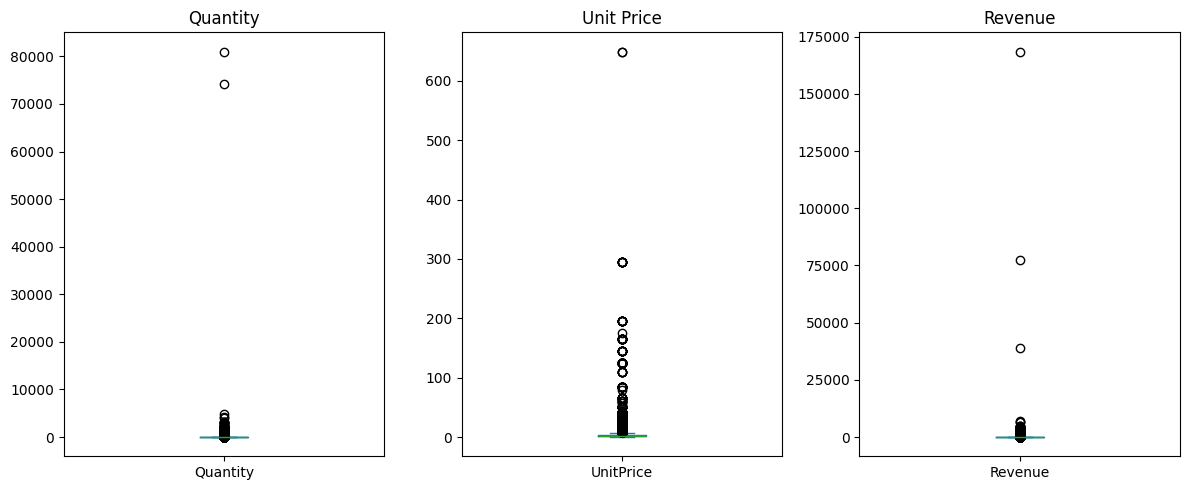

In [17]:
df_purchase[['Quantity', 'UnitPrice', 'Revenue']].plot.box(subplots=True, layout=(1, 3), figsize=(12, 5), title=['Quantity', 'Unit Price', 'Revenue'])
plt.tight_layout()
plt.show()

#### We can see some outliers in the dataset that show instances of higher quantity, unit price, and revenue. These customers are most likely businesses that are buying in bulk and spending alot more than the average customer

In [18]:
df_purchase.nlargest(2, 'Quantity')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue,Year,Month,Day,Hour,Minute,DayOfWeek,IsWeekend
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446,United Kingdom,168469.6,2011,12,9,9,15,4,False
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom,77183.6,2011,1,18,10,1,1,False


In [19]:
df_purchase.nlargest(3, 'UnitPrice')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue,Year,Month,Day,Hour,Minute,DayOfWeek,IsWeekend
222680,556444,22502,PICNIC BASKET WICKER 60 PIECES,60,2011-06-10 15:28:00,649.5,15098,United Kingdom,38970.0,2011,6,10,15,28,4,False
222682,556446,22502,PICNIC BASKET WICKER 60 PIECES,1,2011-06-10 15:33:00,649.5,15098,United Kingdom,649.5,2011,6,10,15,33,4,False
4989,536835,22655,VINTAGE RED KITCHEN CABINET,1,2010-12-02 18:06:00,295.0,13145,United Kingdom,295.0,2010,12,2,18,6,3,False


In [20]:
df_purchase.nlargest(3, 'Revenue')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue,Year,Month,Day,Hour,Minute,DayOfWeek,IsWeekend
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446,United Kingdom,168469.6,2011,12,9,9,15,4,False
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom,77183.6,2011,1,18,10,1,1,False
222680,556444,22502,PICNIC BASKET WICKER 60 PIECES,60,2011-06-10 15:28:00,649.50,15098,United Kingdom,38970.0,2011,6,10,15,28,4,False


#### I want to see the disparity of revenue across all customer ID's, as there is a difference between the average consumer and that of a business, which may be important to note

In [21]:
customer_monetary = df_purchase.groupby('CustomerID')['Revenue'].sum().reset_index()
customer_monetary.sort_values(by='Revenue', ascending=False).head(30)

,CustomerID,Revenue
1689,14646,279138.02
4198,18102,259657.30
3726,17450,194550.79
3007,16446,168472.50
1879,14911,136275.72
55,12415,124564.53
1333,14156,116729.63
3769,17511,91062.38
0,12346,77183.60
2701,16029,72882.09


#### We can see that we are dealing with a dataset that has businesses and your average consumer grouped together. This distinction would probably be made by the RFM segmentation later on but for now I will create a column `IsBusiness` to identify if a customer ID is a business or not. This distinction will be made based on the total revenue the customer spent, if they spent more than 30,000 dollars they will be classified as a business

In [22]:
business_ids = customer_monetary[customer_monetary.Revenue > 30000]['CustomerID']
df_purchase['IsBusiness'] = df_purchase.CustomerID.isin(business_ids)

df_business = df_purchase[df_purchase.IsBusiness].copy()
df_consumers = df_purchase[~df_purchase.IsBusiness].copy()

print(df_business.CustomerID.nunique(), '\n')
print(df_consumers.CustomerID.nunique(), '\n')

31 

4304 



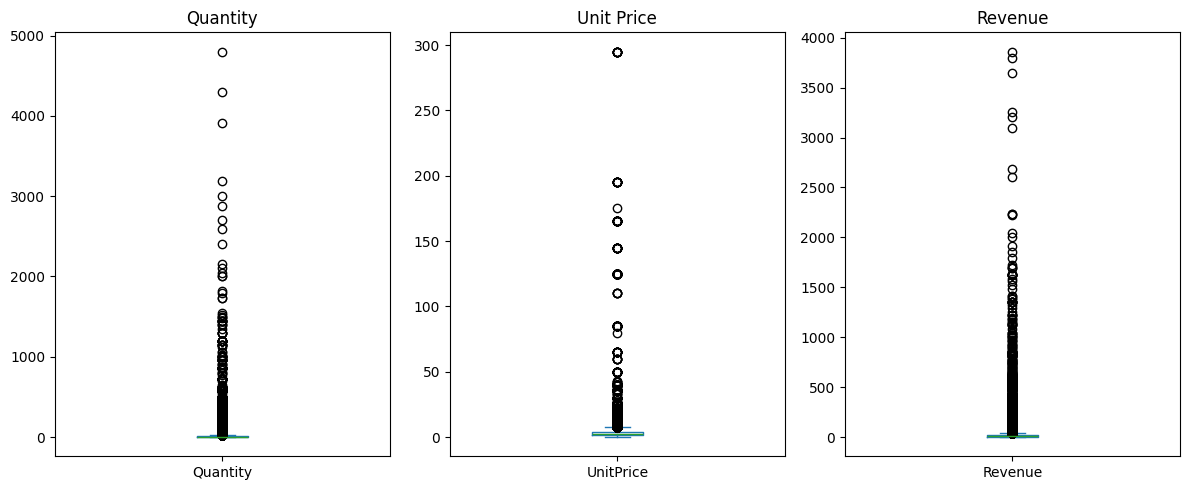

In [23]:
df_consumers[['Quantity', 'UnitPrice', 'Revenue']].plot.box(subplots=True, layout=(1, 3), figsize=(12, 5), title=['Quantity', 'Unit Price', 'Revenue'])
plt.tight_layout()
plt.show()

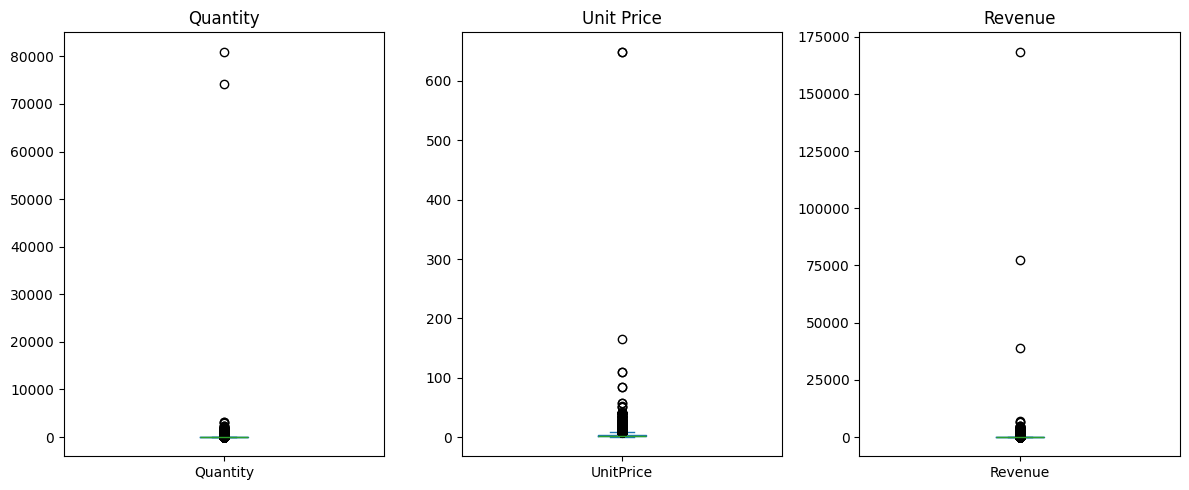

In [24]:
df_business[['Quantity', 'UnitPrice', 'Revenue']].plot.box(subplots=True, layout=(1, 3), figsize=(12, 5), title=['Quantity', 'Unit Price', 'Revenue'])
plt.tight_layout()
plt.show()

In [25]:
df_business.nlargest(2, 'Quantity')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue,Year,Month,Day,Hour,Minute,DayOfWeek,IsWeekend,IsBusiness
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446,United Kingdom,168469.6,2011,12,9,9,15,4,False,True
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom,77183.6,2011,1,18,10,1,1,False,True


In [26]:
df_business.nlargest(2, 'Revenue')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue,Year,Month,Day,Hour,Minute,DayOfWeek,IsWeekend,IsBusiness
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446,United Kingdom,168469.6,2011,12,9,9,15,4,False,True
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom,77183.6,2011,1,18,10,1,1,False,True


#### We can see the typical consumer dataframe now looks evenly distributed but the business customers still deal with outliers. After inspecting them there are two customers that jump out: `CustomerID` 16446 and 12346. These are probably big businesses that frequently purchase from this store causing the skew

#### Now we have three dataframes df_purchase (only debit transactions), df_consumers (segment of customers spending less than 30k a year), df_business (segment of customers that spend more than   30k a year). We'll now further explore this data in our EDA section